#Notebook 04-LSTM.ipynb (versión en celdas planas)

In [1]:
# ==============================
# 1. Montaje de Drive y librerías
# ==============================
import os, glob
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ==============================
# 2. Función para buscar los .npy en TODO el Drive
# ==============================
def find_npy(filename, base_dir="/content/drive/MyDrive"):
    matches = glob.glob(os.path.join(base_dir, "**", filename), recursive=True)
    if not matches:
        raise FileNotFoundError(f"No se encontró {filename} en {base_dir}")
    return matches[0]

X_seq_path = find_npy("X_seq.npy")
X_static_path = find_npy("X_static.npy")
y_path = find_npy("y.npy")

print("Archivos encontrados:")
print("X_seq:", X_seq_path)
print("X_static:", X_static_path)
print("y:", y_path)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# ==============================
# 3. Cargar arrays procesados
# ==============================
X_seq = np.load(X_seq_path)        # (muestras, seq_len, 1)
X_static = np.load(X_static_path)  # (muestras, n_features)
y = np.load(y_path)                # (muestras,)

print("Shapes:")
print("X_seq:", X_seq.shape)
print("X_static:", X_static.shape)
print("y:", y.shape)


Shapes:
X_seq: (48532, 5, 1)
X_static: (48532, 3)
y: (48532,)


In [ ]:
# ==============================
# 4. Split train/test
# ==============================
Xs_train, Xs_test, Xst_train, Xst_test, y_train, y_test = train_test_split(
    X_seq, X_static, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", Xs_train.shape[0])
print("Test size:", Xs_test.shape[0])


Train size: 38825
Test size: 9707


In [ ]:
# ==============================
# 5. Definir arquitectura LSTM híbrida
# ==============================

# Entrada secuencial
seq_input = keras.Input(shape=Xs_train.shape[1:], name="seq_input")  # (seq_len, 1)
x = layers.Masking()(seq_input)  # en caso de padding
x = layers.LSTM(64, return_sequences=False)(x)
x = layers.Dropout(0.3)(x)

# Entrada estática
static_input = keras.Input(shape=(Xst_train.shape[1],), name="static_input")
z = layers.Dense(32, activation="relu")(static_input)

# Concatenación
concat = layers.concatenate([x, z])
h = layers.Dense(64, activation="relu")(concat)
output = layers.Dense(len(np.unique(y)), activation="softmax")(h)

model_lstm = keras.Model(inputs=[seq_input, static_input], outputs=output)

model_lstm.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_lstm.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 5, 1)      │          0 │ seq_input[0][0]   │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 5, 1)      │          0 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 5)         │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     16,896 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        128 │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │        195 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,427 (91.51 KB)

 Trainable params: 23,427 (91.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ==============================
# 6. Callbacks y entrenamiento
# ==============================
save_dir = "/content/drive/MyDrive/football_project/models"
os.makedirs(save_dir, exist_ok=True)

checkpoint_path = os.path.join(save_dir, "lstm_best.keras")

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, save_best_only=True)
]

history = model_lstm.fit(
    [Xs_train, Xst_train], y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

print(f"✅ Modelo guardado en {checkpoint_path}")


Epoch 1/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4800 - loss: 1.0523 - val_accuracy: 0.4921 - val_loss: 1.0404
Epoch 2/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.4910 - loss: 1.0408 - val_accuracy: 0.4917 - val_loss: 1.0404
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4872 - loss: 1.0418 - val_accuracy: 0.4909 - val_loss: 1.0409
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4865 - loss: 1.0427 - val_accuracy: 0.4892 - val_loss: 1.0404
Epoch 5/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4886 - loss: 1.0398 - val_accuracy: 0.4922 - val_loss: 1.0406
Epoch 6/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.4887 - loss: 1.0405 - val_accuracy: 0.4910 - val_loss: 1.0401
Epoch 7/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.4886 - loss: 1.0395 - val_accuracy: 0.4908 - val_loss: 1.0397
Epoch 8/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4900 - loss: 1.0387 - val_accu

In [ ]:
# ==============================
# 7. Evaluación en test
# ==============================
test_loss, test_acc = model_lstm.evaluate([Xs_test, Xst_test], y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


Test Loss: 1.038805365562439
Test Accuracy: 0.48882248997688293


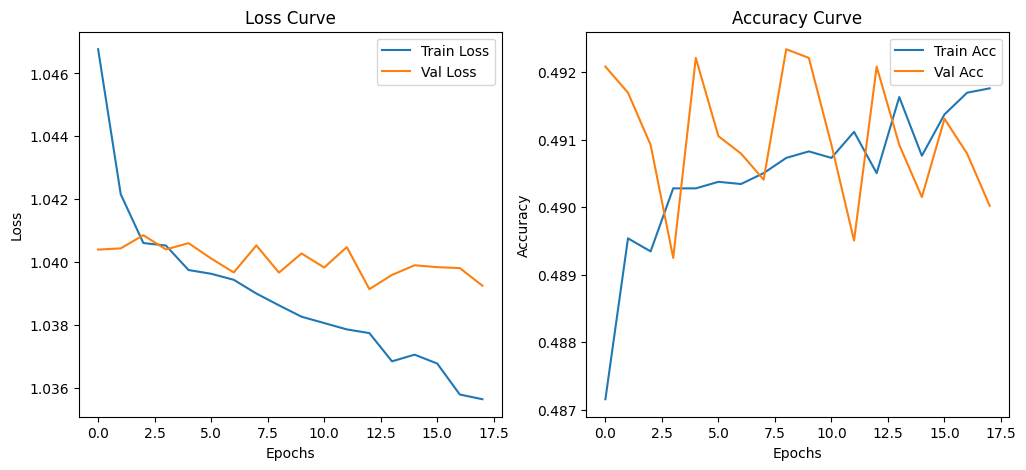

In [ ]:
# ==============================
# 8. Curvas de entrenamiento
# ==============================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy Curve")

plt.show()


#README.md (para carpeta 04/)

# 📘 Notebook 04 - LSTM híbrido

Este notebook implementa un modelo de **Red Neuronal LSTM** para procesar secuencias de eventos de un partido de fútbol, complementadas con información estática del contexto del jugador/equipo.

---

## 📂 Contenido

- `04-LSTM.ipynb` → Notebook en Google Colab con el modelo híbrido.
- Modelos entrenados se guardarán automáticamente en:

##/MyDrive/football_project/models/lstm_best.keras



---

## 🔧 Dependencias

El notebook está preparado para Google Colab con las siguientes librerías principales:

- `numpy`
- `matplotlib`
- `scikit-learn`
- `tensorflow` (>= 2.12)
- `google.colab` (para montar Drive)

No necesitas instalar nada extra en Colab.

---

## 📊 Datos de entrada

El notebook busca automáticamente los arrays `.npy` en tu Google Drive:

- `X_seq.npy` → Secuencias de longitud fija con 1 canal.  
**Shape esperado**: `(muestras, seq_len, 1)`

- `X_static.npy` → Atributos estáticos complementarios (ej: edad, rol, equipo).  
**Shape esperado**: `(muestras, n_features)`

- `y.npy` → Etiquetas de salida (codificadas como enteros).  
**Shape esperado**: `(muestras,)`

---

## 🧠 Modelo LSTM híbrido

El modelo combina:

1. **Entrada secuencial (X_seq)**  
 - `Masking` (manejo de padding)  
 - `LSTM(64)`  
 - `Dropout(0.3)`

2. **Entrada estática (X_static)**  
 - `Dense(32, relu)`

3. **Concatenación**  
 - `Dense(64, relu)`  
 - `Dense(#clases, softmax)`

**Compilación**:  
```python
optimizer="adam"
loss="sparse_categorical_crossentropy"
metrics=["accuracy"]


#📄 README.md (versión extendida con diagrama)

# 📘 Notebook 04 - LSTM híbrido

Este notebook implementa un modelo de **Red Neuronal LSTM** para procesar secuencias de eventos de un partido de fútbol, complementadas con información estática del contexto del jugador/equipo.

---

## 📂 Contenido

- `04-LSTM.ipynb` → Notebook en Google Colab con el modelo híbrido.
- Modelos entrenados se guardarán automáticamente en:
##/MyDrive/football_project/models/lstm_best.keras


---

## 🔧 Dependencias

El notebook está preparado para Google Colab con las siguientes librerías principales:

- `numpy`
- `matplotlib`
- `scikit-learn`
- `tensorflow` (>= 2.12)
- `google.colab` (para montar Drive)

No necesitas instalar nada extra en Colab.

---

## 📊 Datos de entrada

El notebook busca automáticamente los arrays `.npy` en tu Google Drive:

- `X_seq.npy` → Secuencias de longitud fija con 1 canal.  
**Shape esperado**: `(muestras, seq_len, 1)`

- `X_static.npy` → Atributos estáticos complementarios (ej: edad, rol, equipo).  
**Shape esperado**: `(muestras, n_features)`

- `y.npy` → Etiquetas de salida (codificadas como enteros).  
**Shape esperado**: `(muestras,)`

---

## 🧠 Modelo LSTM híbrido

El modelo combina dos entradas:

```mermaid
flowchart LR
  A[📥 X_seq.npy (secuencia)] --> B[LSTM Layer]
  B --> C[Vector secuencial]

  D[📥 X_static.npy (atributos)] --> E[Dense Layer]
  E --> F[Vector estático]

  C --> G[Concatenación]
  F --> G

  G --> H[Dense 64 ReLU]
  H --> I[Dense softmax (clases)]
  I --> J[📤 y (predicción)]
